In [1]:
#Time series data of HD50896 from TESS - 1st part
import os, sys

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import matplotlib.ticker as ticker

import numpy as np

import astropy
from astropy.io import fits
from astropy.io import ascii
import astropy.units as u
# from astropy.utils.data import get_pkg_data_filename   #time-series extraction tool
# from astropy.timeseries import TimeSeries

import lightkurve as lk    #good time-series library

import pandas as pd 

from scipy.optimize import curve_fit

In [2]:
#read from manually downloaded data from MAST
wr40_lc1 = lk.read('tess2021091135823-s0037-0000000466582212-0208-s_lc.fits')
wr40_lc1

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2307.25626282324,nan,nan,2.6289339e-03,777455,nan,nan,nan,nan,nan,nan,nan,nan,10000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2307.2576517364223,nan,nan,2.6289588e-03,777456,nan,nan,nan,nan,nan,nan,nan,nan,10000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2307.2604295627866,2.2082656e+05,5.5142151e+01,2.6290086e-03,777458,1413.30114,1263.64676,2.0950405e+05,5.1611317e+01,1.2095080e+04,1.3433679e+01,2.2082656e+05,5.5142151e+01,1000000000,nan,nan,nan,nan,1413.30114,2.1480648e-04,1263.64676,2.1513105e-04,-1.4058528e-02,-1.7545782e-02
2307.2618184759694,2.2056355e+05,5.5102928e+01,2.6290335e-03,777459,1413.30214,1263.63703,2.0909980e+05,5.1574608e+01,1.2123870e+04,1.3448146e+01,2.2056355e+05,5.5102928e+01,0,nan,nan,nan,nan,1413.30214,2.1508892e-04,1263.63703,2.1566666e-04,-1.3835727e-02,-2.8693104e-02
2307.2840410868866,2.2052795e+05,5.5050316e+01,2.6294321e-03,777475,1413.31371,1263.63760,2.0917492e+05,5.1525364e+01,1.1864621e+04,1.3327682e+01,2.2052795e+05,5.5050316e+01,0,nan,nan,nan,nan,1413.31371,2.1488023e-04,1263.63760,2.1500357e-04,-8.4374733e-05,-2.8995963e-02
2307.285430000302,2.2042553e+05,5.5026703e+01,2.6294573e-03,777476,1413.30987,1263.63216,2.0902519e+05,5.1503262e+01,1.1851396e+04,1.3316722e+01,2.2042553e+05,5.5026703e+01,0,nan,nan,nan,nan,1413.30987,2.1490247e-04,1263.63216,2.1527176e-04,-4.2923465e-03,-3.4851905e-02
2307.2868189134842,2.2042428e+05,5.5029564e+01,2.6294822e-03,777477,1413.31400,1263.63642,2.0908764e+05,5.1505943e+01,1.1829645e+04,1.3307498e+01,2.2042428e+05,5.5029564e+01,0,nan,nan,nan,nan,1413.31400,2.1482796e-04,1263.63642,2.1504023e-04,7.8277575e-05,-2.9798970e-02
2307.288207826666,2.2042222e+05,5.5016262e+01,2.6295071e-03,777478,1413.31463,1263.63286,2.0904394e+05,5.1493492e+01,1.1805396e+04,1.3298120e+01,2.2042222e+05,5.5016262e+01,0,nan,nan,nan,nan,1413.31463,2.1476719e-04,1263.63286,2.1497365e-04,1.3133272e-04,-3.3876166e-02


In [3]:
wr40_lc1.filename

'tess2021091135823-s0037-0000000466582212-0208-s_lc.fits'

Trying to obtain the PDCSAP flux from the time series. However, a little bit of context first.

- **SAP light curve** is summing together the brightness of pixels that fall within an aperture set by any of these survey missions - referred to as the **optimal aperture**, though, still subject to systematic artifacts of the respective mission.

- **PDCSAP light curve** has more treatment than SAP. The PDCSAP pipeline attempts to remove systematic artifacts while keeping planetary transits intact (made with planet detection intentions)

Text(0.5, 1.0, 'PDCSAP Light Curve of WR40 - ts1')

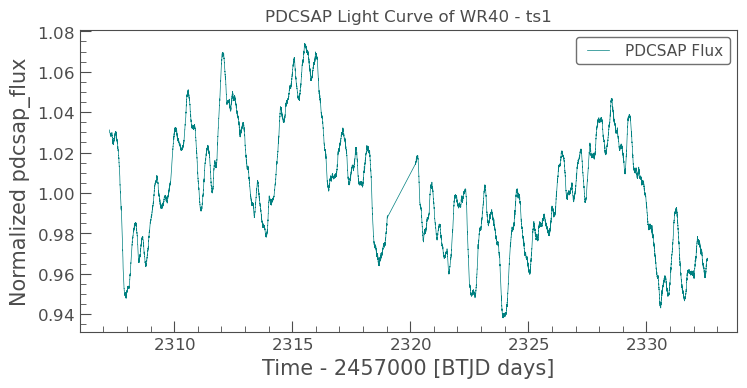

In [4]:
ax = wr40_lc1.plot(column='pdcsap_flux', label='PDCSAP Flux', color='teal', normalize=True)    #PDCSAP flux
ax.set_title('PDCSAP Light Curve of WR40 - ts1')
#hd_lc1.plot(column='sap_flux', label='SAP Flux', color='r', normalize=True, ax=ax);    #SAP flux
#ax.set_xlim(1470, 1471)
#ax.set_ylim(1.005, 1.01)

In [5]:
#timeseries's metadata
wr40_lc1.meta

{'INHERIT': True,
 'EXTNAME': 'PRIMARY',
 'EXTVER': 1,
 'SIMDATA': False,
 'TELESCOP': 'TESS',
 'INSTRUME': 'TESS Photometer',
 'OBJECT': 'TIC 466582212',
 'TICID': 466582212,
 'RADESYS': 'ICRS',
 'RA_OBJ': 166.571680457669,
 'DEC_OBJ': -65.5097882252792,
 'EQUINOX': 2000.0,
 'EXPOSURE': 20.056455663613,
 'TIMEREF': 'SOLARSYSTEM',
 'TASSIGN': 'SPACECRAFT',
 'TIMESYS': 'TDB',
 'BJDREFI': 2457000,
 'BJDREFF': 0.0,
 'TIMEUNIT': 'd',
 'TELAPSE': 25.323807656077,
 'LIVETIME': 20.056455663612947,
 'TSTART': 2307.25834630887,
 'TSTOP': 2332.582153733466,
 'DATE-OBS': '2021-04-02T18:10:51.937',
 'DATE-END': '2021-04-28T01:57:08.899',
 'DEADC': 0.792,
 'TIMEPIXR': 0.5,
 'TIERRELA': 1.16e-05,
 'INT_TIME': 1.98,
 'READTIME': 0.02,
 'FRAMETIM': 2.0,
 'NUM_FRM': 60,
 'TIMEDEL': 0.001388888888888889,
 'BACKAPP': True,
 'DEADAPP': True,
 'VIGNAPP': True,
 'GAINA': 5.25,
 'GAINB': 5.239999771118164,
 'GAINC': 5.239999771118164,
 'GAIND': 5.239999771118164,
 'READNOIA': 10.079999923706055,
 'READNOIB':

### Lomb-Scargle Periodogram of HD 050896

In [6]:
#Lomb-Scargle Periodogram - normalised to parts per million
pg_wr40_lc1 = wr40_lc1.normalize(unit='ppm').to_periodogram()
pg_wr40_lc1

LombScarglePeriodogram(ID: TIC 466582212)

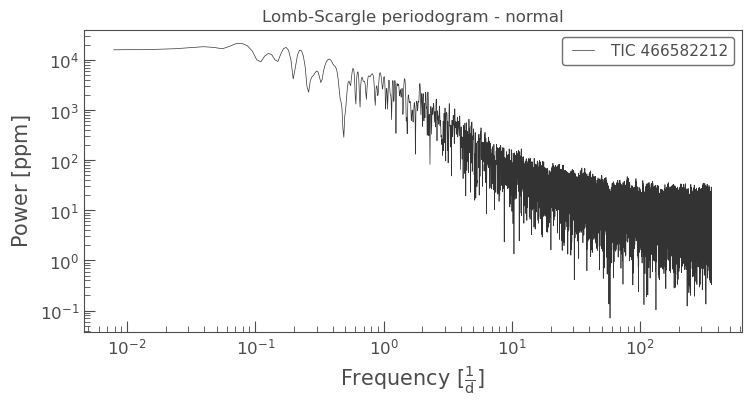

In [7]:
#Inspecting the periodogram
ax = pg_wr40_lc1.plot(view='frequency', scale='log')
#ax.set_xlim(0,20)
ax.set_title('Lomb-Scargle periodogram - normal')
plt.savefig('LS_lc1_log')

In [8]:
pg_wr40_lc1.period_at_max_power   #period at max power

<Quantity 14.0672388 d>

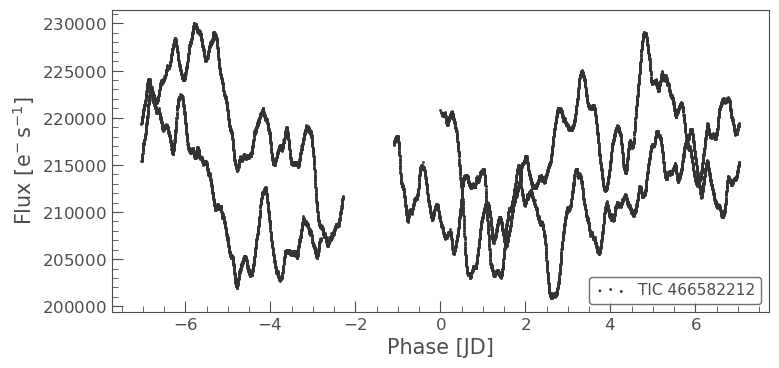

In [9]:
#Folding light curve using max power period
wr40_lc1.fold(period=pg_wr40_lc1.period_at_max_power).scatter()

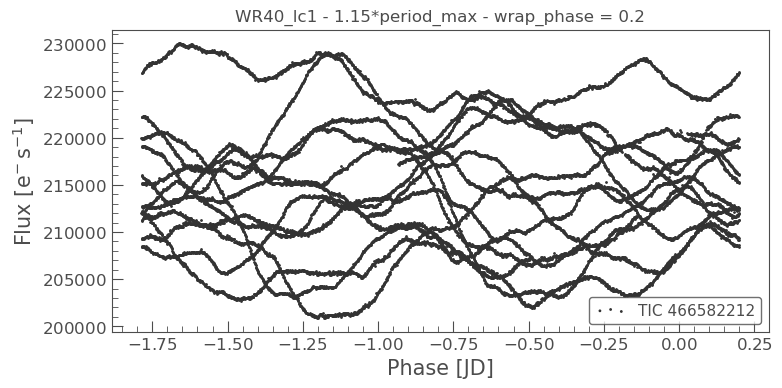

In [21]:
#Testing with folding params & then remaking periodogram
wr40_lc1.fold(period=1.15*pg_wr40_lc1.period_at_max_power, wrap_phase=0.2).scatter()
plt.title('WR40_lc1 - 1.15*period_max - wrap_phase = 0.2')
plt.savefig('wr40_lc1_folded')

Hmm... Is this the best this star can do in terms of time series??? Ask Ian. 

13.379217272113161 d


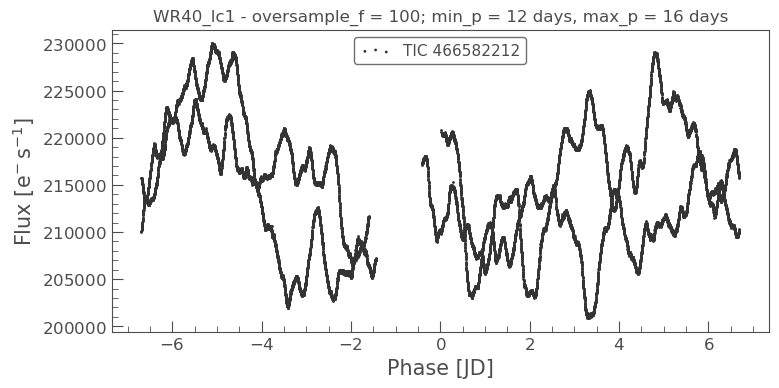

In [22]:
#Increasing oversampling frequency = 100
pg_wr40_lc1 = wr40_lc1.normalize(unit='ppm').to_periodogram(minimum_period=12*u.day, maximum_period=16*u.day, oversample_factor=100)
print(pg_wr40_lc1.period_at_max_power)
wr40_lc1.fold(period=pg_wr40_lc1.period_at_max_power).scatter()
plt.title('WR40_lc1 - oversample_f = 100; min_p = 12 days, max_p = 16 days')
plt.savefig('wr40_lc1_edited_fold')

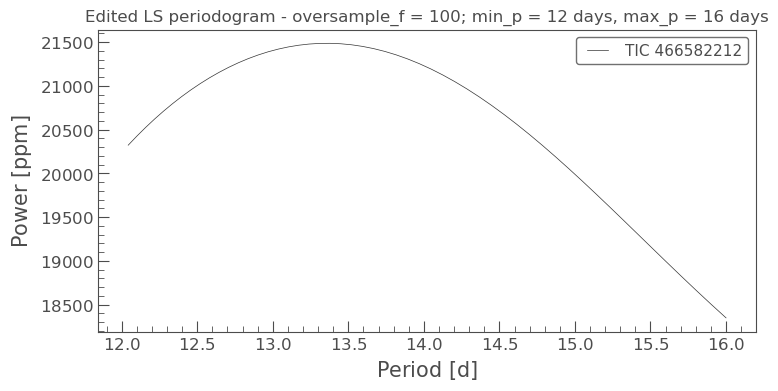

In [23]:
#Inspecting LS post-modification
ax = pg_wr40_lc1.plot(view='period', scale='linear')
#ax.set_xlim(0,20)
ax.set_title('Edited LS periodogram - oversample_f = 100; min_p = 12 days, max_p = 16 days')
plt.savefig('wr40_lc1_edited_ls')

In [24]:
#Writing relevant light curves into ascii files
wr40_lc1.write("wr40_lc1.txt", format="ascii.fixed_width", overwrite=True)